In [1]:
!pip install -q "git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/CLIP"
!pip install -q "git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/ml-mobileclip"
!pip install -q "git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/lvis-api"
!pip install -q "git+https://github.com/THU-MIG/yoloe.git"

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 73.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 7.8 MB/s eta 0:00:00


In [2]:
!wget -q https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_blt.pt
!pip install -q roboflow supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 126.7 MB/s eta 0:00:00


In [3]:
!pip install jupyter_bbox_widget
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.7 MB/s eta 0:00:00


In [4]:
from huggingface_hub import hf_hub_download

path = hf_hub_download(repo_id="jameslahm/yoloe", filename="yoloe-v8l-seg.pt", local_dir='.')
path = hf_hub_download(repo_id="jameslahm/yoloe", filename="yoloe-v8l-seg-pf.pt", local_dir='.')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


yoloe-v8l-seg.pt:   0%|          | 0.00/107M [00:00<?, ?B/s]

yoloe-v8l-seg-pf.pt:   0%|          | 0.00/103M [00:00<?, ?B/s]

In [5]:
import supervision as sv
from ultralytics import YOLOE
from PIL import Image

In [6]:
import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

# Glass Detection


In [71]:
IS_COLAB = True
SOURCE_IMAGE_PATH ="/content/Glass_1.jpg"
NAMES = ['glass']

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget(classes=NAMES)
widget.image = encode_image("/content/Glass_1.jpg")
widget

BBoxWidget(classes=['glass'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377…

In [72]:
widget.bboxes

[{'x': 175, 'y': 38, 'width': 197, 'height': 462, 'label': 'glass'}]

In [73]:
import numpy as np
default_box=[
    {'x': 175, 'y': 38, 'width': 197, 'height': 462, 'label': 'glass'}
]
boxes=widget.bboxes if widget.bboxes else default_box
bboxes=np.array([
    [
        box['x'],
        box['y'],
        box['x']+box['width'],
        box['y']+box['height']
    ] for box in boxes
], dtype=np.float64)
cls=np.array([NAMES.index(box['label']) for box in boxes], dtype=np.int32)


0: 640x640 1 object0, 147.1ms
Speed: 5.1ms preprocess, 147.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 glass, 64.8ms
Speed: 2.4ms preprocess, 64.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


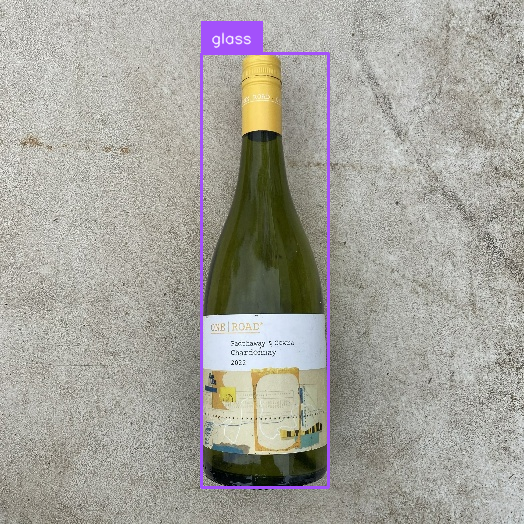

In [75]:
from ultralytics import YOLOE
from ultralytics.models.yolo.yoloe.predict_vp import YOLOEVPSegPredictor

model = YOLOE("yoloe-v8l-seg.pt").cuda()
prompts = dict(bboxes=bboxes, cls=cls)
TARGET_IMAGE_PATH = "/content/test_glass/Glass_13.jpg"
source_image = Image.open(SOURCE_IMAGE_PATH)
target_image = Image.open(TARGET_IMAGE_PATH)

model.predict(source_image, prompts=prompts, predictor=YOLOEVPSegPredictor, return_vpe=True)
model.set_classes(NAMES, model.predictor.vpe)
model.predictor = None

results = model.predict(target_image)
# results[0].show()

detections = sv.Detections.from_ultralytics(results[0])

annotated_image = target_image.copy()
annotated_image = sv.BoxAnnotator().annotate(scene=annotated_image, detections=detections)
annotated_image = sv.LabelAnnotator().annotate(scene=annotated_image, detections=detections)

annotated_image

# Test on Glass dataset(20 images)

In [80]:
import os, glob
TARGET_FOLDER = "/content/test"
OUT_FOLDER = "/content/outputs_glass"
os.makedirs(OUT_FOLDER, exist_ok=True)

image_paths = glob.glob(os.path.join(TARGET_FOLDER, "*.jpg"))

for img_path in image_paths:
    results = model.predict(img_path, conf=0.25)
    detections = sv.Detections.from_ultralytics(results[0])

    img = Image.open(img_path).convert("RGB")
    annotated = sv.BoxAnnotator().annotate(scene=np.array(img), detections=detections)
    annotated = sv.LabelAnnotator().annotate(scene=annotated, detections=detections)

    save_path = os.path.join(OUT_FOLDER, os.path.basename(img_path))
    Image.fromarray(annotated).save(save_path)
    print(f"Saved result → {save_path}")

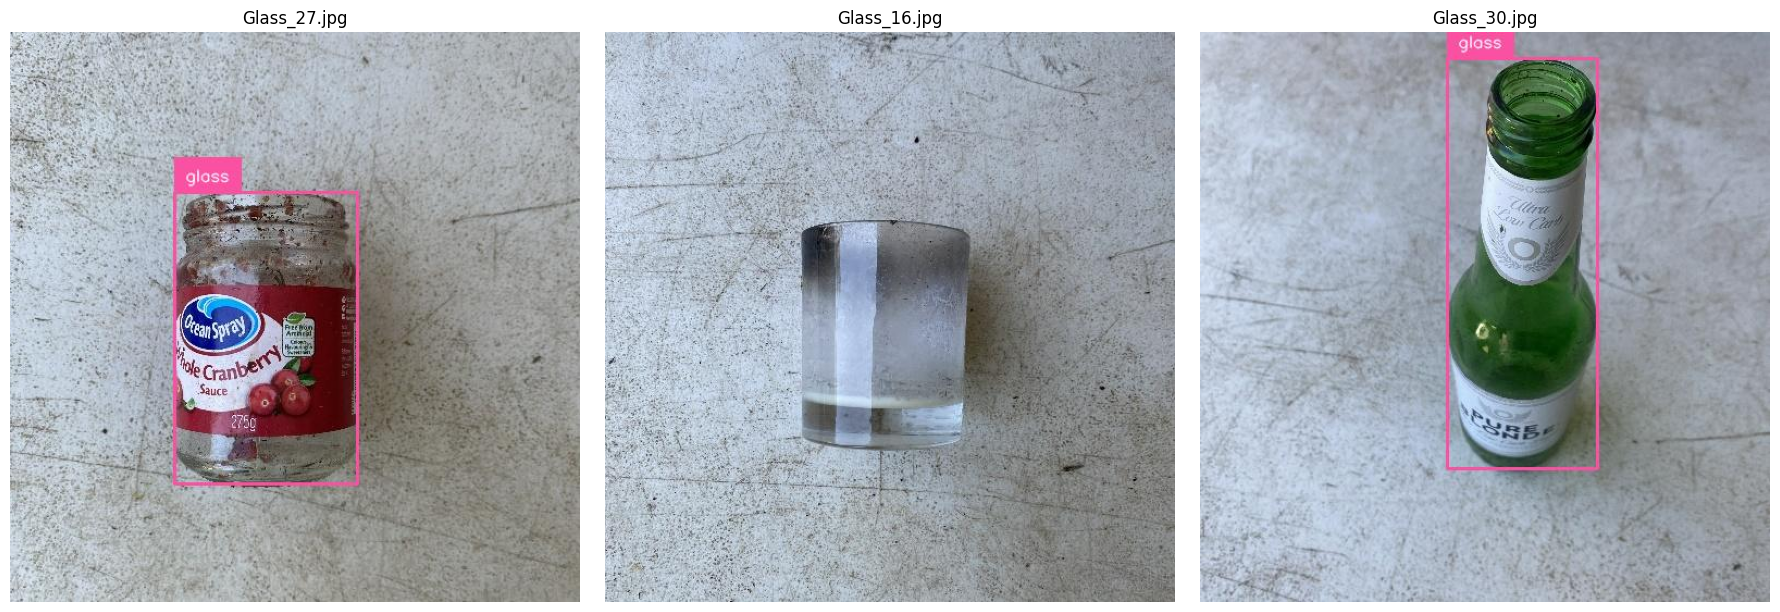

In [83]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import glob, os

# pick any 3 images from your output folder
OUT_FOLDER = "/content/outputs"
images = glob.glob(os.path.join(OUT_FOLDER, "*.jpg"))
sampled = random.sample(images, 3)  # pick 3 random ones

plt.figure(figsize=(18, 6))
for i, img_path in enumerate(sampled):
    img = Image.open(img_path)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path))
    plt.axis("off")
plt.tight_layout()
plt.show()


# Food Detection


In [84]:
IS_COLAB = True
SOURCE_IMAGE_PATH ="/content/Food Organics_1.jpg"
NAMES = ['Bio-Waste']

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget(classes=NAMES)
widget.image = encode_image(SOURCE_IMAGE_PATH)
widget

BBoxWidget(classes=['Bio-Waste'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#…

In [85]:
widget.bboxes

[{'x': 68, 'y': 109, 'width': 388, 'height': 355, 'label': 'Bio-Waste'}]

In [86]:
import numpy as np
default_box=[
    {'x': 68, 'y': 109, 'width': 388, 'height': 355, 'label': 'Bio-Waste'}
]
boxes=widget.bboxes if widget.bboxes else default_box
bboxes=np.array([
    [
        box['x'],
        box['y'],
        box['x']+box['width'],
        box['y']+box['height']
    ] for box in boxes
], dtype=np.float64)
cls=np.array([NAMES.index(box['label']) for box in boxes], dtype=np.int32)


0: 640x640 1 object0, 149.0ms
Speed: 3.0ms preprocess, 149.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Bio-Waste, 57.3ms
Speed: 2.3ms preprocess, 57.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


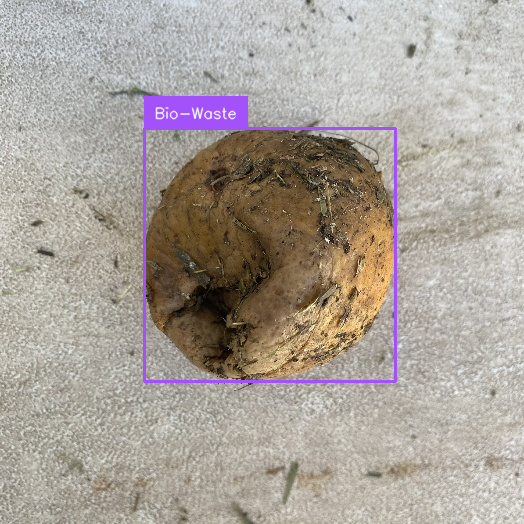

In [89]:
from ultralytics import YOLOE
from ultralytics.models.yolo.yoloe.predict_vp import YOLOEVPSegPredictor

model = YOLOE("yoloe-v8l-seg.pt").cuda()
prompts = dict(bboxes=bboxes, cls=cls)
TARGET_IMAGE_PATH = "/content/test_food/Food Organics_2.jpg"
source_image = Image.open(SOURCE_IMAGE_PATH)
target_image = Image.open(TARGET_IMAGE_PATH)

model.predict(source_image, prompts=prompts, predictor=YOLOEVPSegPredictor, return_vpe=True)
model.set_classes(NAMES, model.predictor.vpe)
model.predictor = None

results = model.predict(target_image)
# results[0].show()

detections = sv.Detections.from_ultralytics(results[0])

annotated_image = target_image.copy()
annotated_image = sv.BoxAnnotator().annotate(scene=annotated_image, detections=detections)
annotated_image = sv.LabelAnnotator().annotate(scene=annotated_image, detections=detections)

annotated_image

In [90]:
import os, glob
TARGET_FOLDER = "/content/test_food"
OUT_FOLDER = "/content/outputs_food"
os.makedirs(OUT_FOLDER, exist_ok=True)

image_paths = glob.glob(os.path.join(TARGET_FOLDER, "*.jpg"))

for img_path in image_paths:
    results = model.predict(img_path, conf=0.25)
    detections = sv.Detections.from_ultralytics(results[0])

    img = Image.open(img_path).convert("RGB")
    annotated = sv.BoxAnnotator().annotate(scene=np.array(img), detections=detections)
    annotated = sv.LabelAnnotator().annotate(scene=annotated, detections=detections)

    save_path = os.path.join(OUT_FOLDER, os.path.basename(img_path))
    Image.fromarray(annotated).save(save_path)
    print(f"Saved result → {save_path}")


image 1/1 /content/test_food/Food Organics_26.jpg: 640x640 1 Bio-Waste, 76.2ms
Speed: 2.7ms preprocess, 76.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Saved result → /content/outputs_food/Food Organics_26.jpg

image 1/1 /content/test_food/Food Organics_29.jpg: 640x640 (no detections), 76.1ms
Speed: 2.3ms preprocess, 76.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Saved result → /content/outputs_food/Food Organics_29.jpg

image 1/1 /content/test_food/Food Organics_1.jpg: 640x640 1 Bio-Waste, 45.5ms
Speed: 2.3ms preprocess, 45.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Saved result → /content/outputs_food/Food Organics_1.jpg

image 1/1 /content/test_food/Food Organics_4.jpg: 640x640 (no detections), 45.6ms
Speed: 2.5ms preprocess, 45.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Saved result → /content/outputs_food/Food Organics_4.jpg

image 1/1 /content/test_food/Food Organics_2.jpg: 640x6

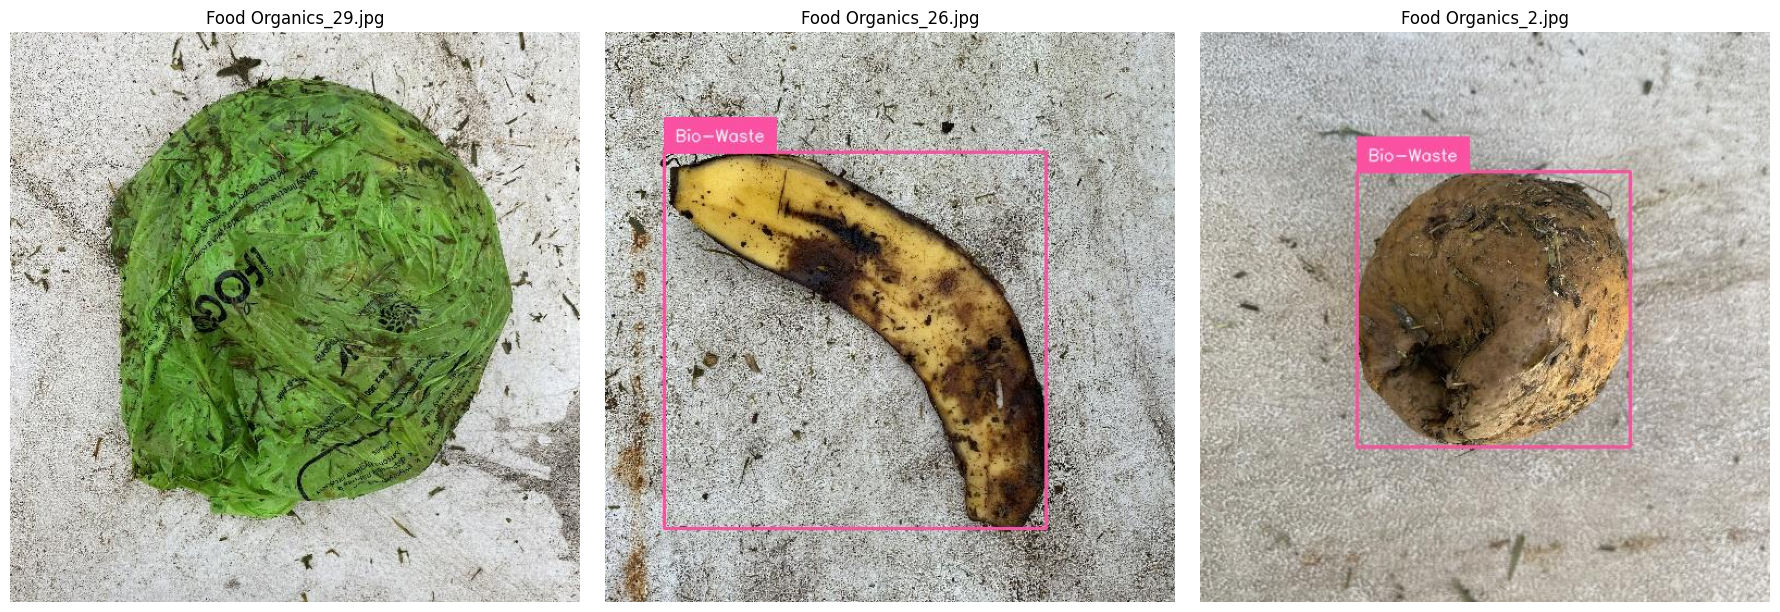

In [92]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import glob, os

# pick any 3 images from your output folder
OUT_FOLDER = "/content/outputs_food"
images = glob.glob(os.path.join(OUT_FOLDER, "*.jpg"))
sampled = random.sample(images, 3)  # pick 3 random ones

plt.figure(figsize=(18, 6))
for i, img_path in enumerate(sampled):
    img = Image.open(img_path)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path))
    plt.axis("off")
plt.tight_layout()
plt.show()
